In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
# ps4 = pd.read_csv("ps4_reviews.csv", engine='python')
d4 = pd.read_csv("reviews2.csv", engine='python')

In [3]:
# ps4_list = ps4['comments'].tolist()
d4_list = d4['comments'].tolist()

In [4]:
# convert all items to str
d4_list = [str(i) for i in d4_list]

In [5]:
# check if all items are str
all(isinstance(n, str) for n in d4_list)

True

In [92]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['love','controller']
stopwords.extend(newStopWords)
# stopwords.append(' 'controller')

In [93]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [7]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [8]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

# Stemming and tokenizing

In [9]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in d4_list:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 113122 items in vocab_frame


# Tfidf

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, max_features=200000,
                                 min_df=0.015, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,2))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(d4_list) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

Wall time: 4.1 s
(6288, 123)


In [12]:
terms = tfidf_vectorizer.get_feature_names()

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

In [14]:
from sklearn.cluster import KMeans

num_clusters = 6

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 3.39 s


In [15]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster1.pkl')

km = joblib.load('doc_cluster1.pkl')
clusters = km.labels_.tolist()

In [16]:
reviews = {'review': d4_list, 'cluster': clusters}
df_d4 = pd.DataFrame(reviews, index = [clusters], columns = ['review', 'cluster'])

In [17]:
df_d4['cluster'].value_counts() 

4    2435
3    1668
5     860
2     469
0     433
1     423
Name: cluster, dtype: int64

In [26]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :7]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print() #add whitespace
    
#     print("Cluster %d titles:" % i, end='')
#     for title in df_ps4.loc[i]['review'].values.tolist():
#         print(' %s,' % title, end='')
#     print() #add whitespace
#     print() #add whitespace

Top terms per cluster:

Cluster 0 words: try, holding, connected, great, left, brand, brand,
Cluster 1 words: battery, wanted, does, try, life, little, make,
Cluster 2 words: ordered, fine, gift, holding, work, month, brand,
Cluster 3 words: great, work, gift, thank, item, remote, quick,
Cluster 4 words: ps4, controllers, new, great, work, work, great,
Cluster 5 words: little, try, returning, started, touch, new, because,


# Wordcloud


In [19]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
text = " ".join(review for review in df_d4.review[3])
print ("There are {} words in the combination of all review.".format(len(text)))

There are 374625 words in the combination of all review.


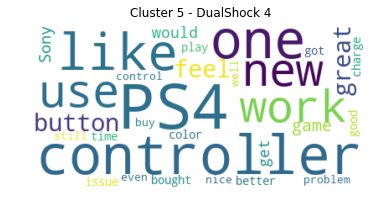

In [120]:
# Generate a word cloud image

wordcloud = WordCloud(background_color="white", max_words=30, stopwords=stopwords).generate(text)

# Display the generated image:
# the matplotlib way:
plt.title("Cluster 5 - DualShock 4")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.margins(x=0, y=0)
plt.show()
wordcloud.to_file("first_review.png")

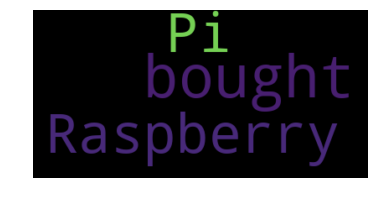

In [46]:
# Start with one review:
text = 'I bought this for my Raspberry Pi 3 and I'

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
df_d4.review.loc[df_d4['cluster'] == 3]

3    Flawless as always.. Bought this particular Ca...
3    Works perfectly. Use it everyday and haven't h...
3    When my original playstation buttons broke, I ...
3    perfect - the other one started having issues ...
3    Works perfect. Packaging perfect. Less expensi...
3    Works perfectly with the Dual Shock 4 Wireless...
3    Worked perfect for 6 months, but now the left ...
3    Works perfect. Definitely was not a used one l...
3    2nd controller so me and the honey can play ga...
3    I recently started playing video games with my...
3    Bought one controller to replace one that was ...
3    The item came in great condition and works per...
3    Arrived on time and as described! We HAD to or...
3    Just a cheaper option other than buying it fro...
3    I wasn't expecting the blue light...but everyt...
3    Great! Husband needed another one & this one w...
3    Love this controller.  Currently using it to p...
3    Everything works perfectly, just bummed it did...
3    Works

# Visualization

In [ ]:
import os
from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'ps4, original, gaming', 
                 1: 'ps, many, playstation', 
                 2: 'sony, hard, drive, amazon', 
                 3: 'tv, 4k, 4k, need, fine', 
                 4: 'updated, easy, pretty, gaming'}

In [ ]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=ps4_list)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the botto m edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)